# Deep Convolutional Generative Adversarial Network

# **CIFAR-10 Small Object Photograph Dataset** <br>

CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

These are very small images, much smaller than a typical photograph, and the dataset is intended for computer vision research.

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

In [3]:
# To generate GIFs
!pip install -q imageio

In [51]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape





from IPython import display

### Load and prepare the dataset

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [6]:
tfds.list_builders()
builder = tfds.builder("cifar10")
builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:07<00:00,  7.33s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:10<00:00, 10.11s/ url]
                                                                        

Dataset cifar10 downloaded and prepared to /Users/miguelfrutossoriano/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
print(builder.info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/Users/miguelfrutossoriano/tensorflow_datasets/cifar10/3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {L

In [8]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

In [15]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (32, 32))
  return image, label

In [16]:
train_dataset = train_dataset_raw.map(format_example)

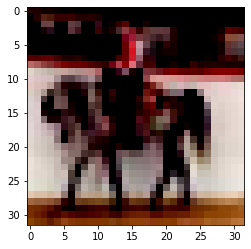

In [17]:
for image, label in train_dataset.take(1):
  plt.imshow(image, interpolation='nearest')

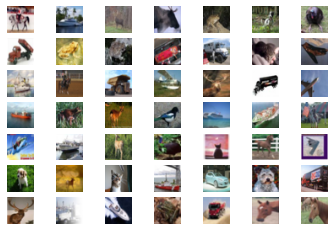

In [18]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1) / 2.0
  plt.imshow(image)
  i = i + 1
plt.show()

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 32x32x3. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

## GENERATOR WORKFLOW

0. Objective: This Generator will convert a 100-dimensional vector into a 2D matrix with 32x32x3 or 3072 values with range [-1,1]. GANs convert 100 random numbers (latent space) with a uniform distribution (Gaussian) into a desired image. Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.
*  - Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers. <space><space>*<space>
*  - Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].<space><space>*<space>
<br>
1. A hidden Dense layer, that has enough nodes, is used  to represent a low resolution image of the output image, in this case an image of 4x4 pixels and 3 color channels is used, i.e. 48 nodes. <br>
<br>
2. Once you have this low resolution "image" we can now move on to increasing the resolution of convolutional layers by upsampling (Conv2DTranspose layers). That will be configured with a 2x2 step that will quadruple the area of the input feature map. <br>
<br>
3. We will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models. <br>
<br>
4. The output layer of the model is a Conv2D with three filters for the three required channels and a kernel size of 3×3 and ‘same‘ padding, designed to create a single feature map and preserve its dimensions at 32 x 32 x 3 pixels. <br>
<br>
5. A tanh activation is used to ensure output values are in the desired range of [-1,1], a current best practice. <br>
<br>
Source: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [44]:
# define the size of the latent space
latent_dim = 100
def make_generator_model(latent_dim):
    # TODO1: Put your code here
    model = Sequential()
    # foundation for 4x4image x3colors = 48nodes
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
     # upsample to 8x8image x 3colors = 192nodes
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16image x 3colors = 768nodes
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32image x 3 colors = 3072nodes
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model



TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-44-47174a4f69a2>, line 28)

In [67]:
generator = make_generator_model(latent_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                              

Use the (as yet untrained) generator to create an image.

In [68]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

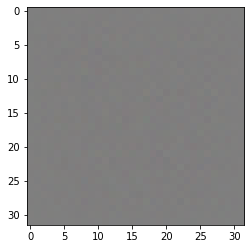

In [69]:
# scale pixel values from [-1,1] to [0,1]
plt.imshow((generated_image[0, :, :, :] + 1) / 2)

### The Discriminator

The discriminator is a CNN-based image classifier.

## DISCRIMINATOR WORKFLOW

0. Objective: The discriminator model should take a sample image as input and a "real" or "fake" conclusion as an output (binary calssification problem).
*  - Inputs:  Image with three color channel and 32×32 pixels in size. <space><space>*<space>
*  - Outputs: Binary classification, likelihood the sample is real (or fake). <space><space>*<space>

1. Structure:
*  1. Normal Convolutional Layer. <space><space>*<space>
*  2. Three Convolutional layers using 2x2 stride to downsample the imput image. <space><space>*<space>
*  3. No pooling layers. <space><space>*<space>
*  4. Single node in the output layer with sigmoid function (recommended for binary class problems). <space><space>*<space>
2. Best Practices:
*  1. Using LeakyRelu instead of Relu. <space><space>*<space>
*  2. Using Dropout. <space><space>*<space>
*  2.  Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5. <space><space>*<space>
Source: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [70]:

def make_discriminator_model(in_shape=(32,32,3)):
	# TODO2: Put your code here
    model = Sequential()
	# normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
  

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [71]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 256)        

/Users/miguelfrutossoriano/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [72]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [73]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [74]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [75]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [76]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [77]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [78]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [79]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [80]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7,7))

  print(predictions.shape[0])
  for i in range(predictions.shape[0]):
      plt.subplot(7, 7, 1 + i)
      image = (predictions[i, :, :, :] + 1)/ 2.0
      plt.imshow(image)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [81]:
#!rm -rf training_checkpoints

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

49


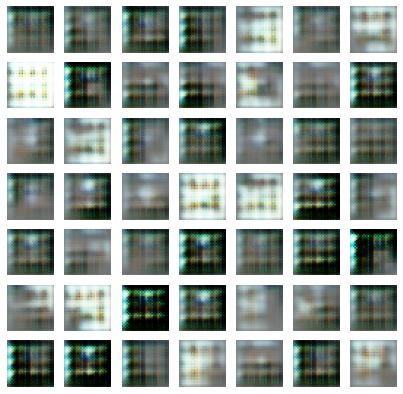

Time for epoch 2 is 471.68839502334595 sec


KeyboardInterrupt: 

In [82]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset_shuffled, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)